# Chilean Growth Slowdown Analysis

This notebook demonstrates how to use the replication code for Toni, Paniagua & Ordenes (2023).

**Paper:** Policy Changes and Growth Slowdown: Assessing the Lost Decade of the Latin American Miracle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import project modules
import sys
sys.path.insert(0, '..')

from chilean_growth.config import DONOR_POOL_GROUP_II, TREATMENT_YEAR, RANDOM_SEED
from chilean_growth.data_loader import assemble_panel_data
from chilean_growth.synthetic_control import fit_synthetic_control, placebo_test
from chilean_growth.causal_impact import fit_bsts_model, summarize_impact
from chilean_growth.visualization import plot_scm_main, plot_scm_trend

# Set random seed
np.random.seed(RANDOM_SEED)

## 1. Load Data

Load panel data from World Bank, Penn World Table, and other sources.

In [2]:
# Load or fetch data
df = assemble_panel_data()

print(f"Panel data shape: {df.shape}")
print(f"Countries: {df['country'].nunique()}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")
df.head()

Fetching World Bank data...
Fetched gdp_per_capita: 690 obs
Fetched gdp_per_capita_ppp: 690 obs
Fetched population_growth: 690 obs
Fetched life_expectancy: 690 obs
Fetched adolescent_fertility: 690 obs
Fetched birth_rate: 690 obs
Fetched gov_consumption: 690 obs
Fetching trade openness...
Fetching schooling data...
Using World Bank gross capital formation proxy...
Fetched gross_capital_formation: 690 obs
Panel data assembled: 690 observations
Countries: 23
Years: 1990 - 2019
Panel data shape: (690, 13)
Countries: 23
Years: 1990 - 2019


,country,year,gdp_per_capita,gdp_per_capita_ppp,population_growth,life_expectancy,adolescent_fertility,birth_rate,gov_consumption,trade_openness,mean_years_schooling,gross_capital_formation,country_name
0,ARG,1990,8115.093864,17007.284432,1.491575,71.615,70.303,22.078,3.135428,14.990859,7.295557,13.996982,Argentina
1,ARG,1991,8729.823185,18295.609200,1.437880,72.020,70.591,21.914,3.321761,13.753054,7.413126,14.636977,Argentina
2,ARG,1992,9293.186923,19476.284061,1.384381,72.096,69.884,21.726,2.975538,14.730981,NaN,16.702406,Argentina
3,ARG,1993,9920.673586,20791.345148,1.353640,72.303,70.028,21.596,13.510378,16.223151,NaN,19.688110,Argentina
4,ARG,1994,10359.892720,21711.842788,1.340138,72.732,70.492,21.414,13.186904,18.134346,7.086775,19.965623,Argentina


## 2. Synthetic Control Method

Fit SCM to estimate what Chile's GDP would have been without the 2014 policy changes.

In [3]:
# Fit synthetic control
result = fit_synthetic_control(
    df=df,
    outcome_var="gdp_per_capita",
    treated_unit="CHL",
    treatment_year=TREATMENT_YEAR,
    donor_pool=DONOR_POOL_GROUP_II,
)

# Display weights
print("Optimal Weights:")
print(result.weights[result.weights > 0.01].sort_values(ascending=False))

Dropping 1 predictors with missing values
Optimal Weights:
CRI    0.414498
CHN    0.263964
URY    0.204216
DOM    0.069091
AUS    0.048230
Name: weight, dtype: float64


In [4]:
# Model fit statistics
print(f"Pre-treatment RMSPE:  {result.rmspe_pre:.2f}")
print(f"Post-treatment RMSPE: {result.rmspe_post:.2f}")
print(f"RMSPE Ratio:          {result.rmspe_ratio:.2f}")

Pre-treatment RMSPE:  440.30
Post-treatment RMSPE: 889.29
RMSPE Ratio:          2.02


In [5]:
# Predictor balance
result.predictor_balance

,Actual,Synthetic,Sample Mean
population_growth,1.214489,1.214502,1.421562
life_expectancy,77.108917,75.470954,72.071544
adolescent_fertility,57.994792,55.288177,67.232672
birth_rate,16.617083,17.664354,21.275250
gov_consumption,11.376506,13.750679,13.950481
gross_capital_formation,25.400201,25.402398,22.365702
trade_openness,63.156447,60.644230,57.952479
gdp_per_capita_1990,5290.536948,6414.219029,9601.730483
gdp_per_capita_1995,7201.131004,7413.854344,10331.837701
gdp_per_capita_2000,8465.353033,8555.959512,11843.692688


## 3. Visualize Results

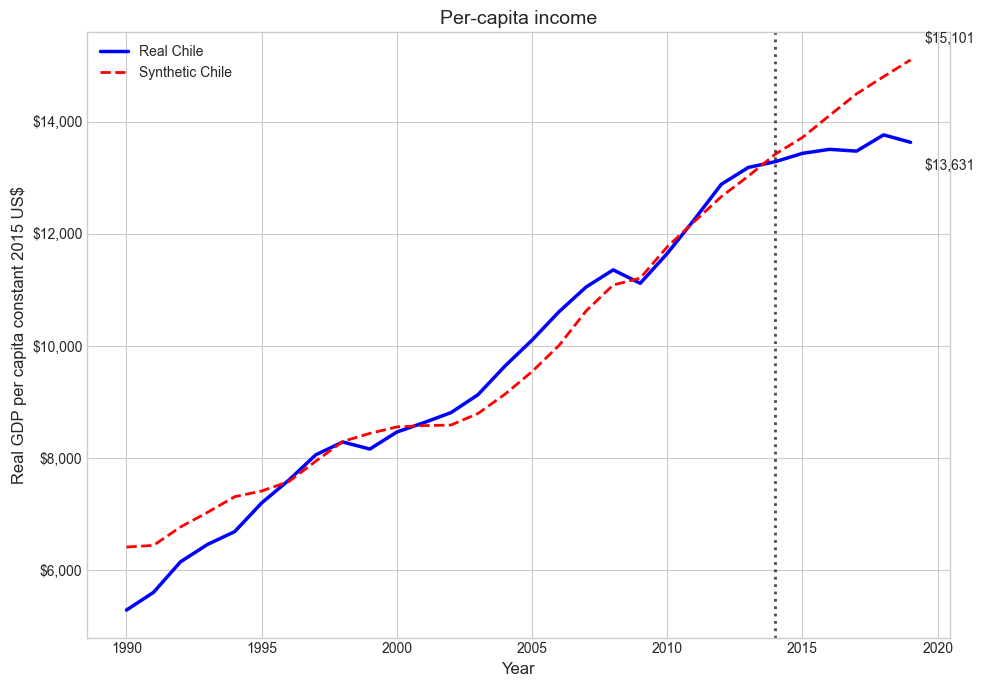

In [6]:
# Plot main result
plot_scm_main(result)
plt.show()

/Users/ggoni/analysis/papers/chilean-growth/.venv/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


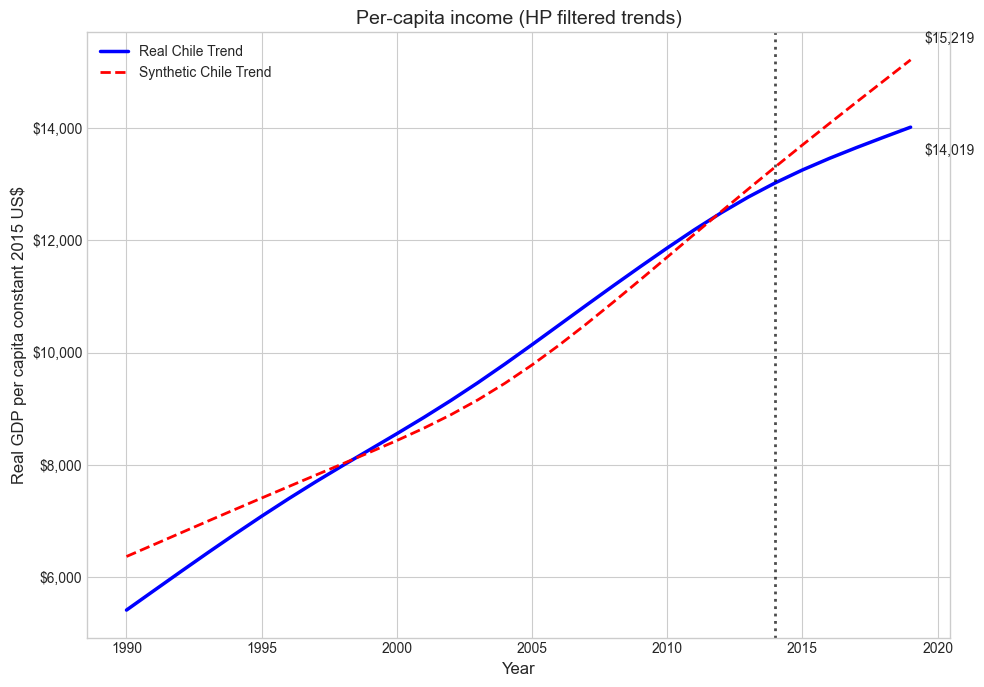

In [7]:
# Plot HP-filtered trends
plot_scm_trend(result)
plt.show()

In [8]:
# Treatment effect
final_year = result.actual.index[-1]
gap = result.gap.loc[final_year]
pct = (gap / result.synthetic.loc[final_year]) * 100

print(f"Treatment Effect ({final_year}):")
print(f"  Actual Chile:    ${result.actual.loc[final_year]:,.0f}")
print(f"  Synthetic Chile: ${result.synthetic.loc[final_year]:,.0f}")
print(f"  Gap:             ${gap:,.0f} ({pct:.1f}%)")

Treatment Effect (2019):
  Actual Chile:    $13,631
  Synthetic Chile: $15,101
  Gap:             $-1,470 (-9.7%)


## 4. BSTS Analysis

Bayesian Structural Time Series for causal inference with uncertainty quantification.

In [9]:
# Fit BSTS model
bsts_result = fit_bsts_model(
    df=df,
    outcome_var="gdp_per_capita",
    treated_unit="CHL",
    treatment_year=TREATMENT_YEAR,
)

# Print summary
print(summarize_impact(bsts_result))


Causal Impact Analysis Summary

Post-treatment period: 2014 - 2019

Average values:
  - Actual:    $13,515
  - Predicted: $15,218
  - Effect:    $-1,702 (-11.2%)

Cumulative effect: $-10,214

Final year (2019):
  - Actual:    $13,631
  - Predicted: $15,547
  - Effect:    $-1,916

Statistical significance:
  - Posterior mean: $-1,702
  - Posterior std:  $645
  - P-value:        0.000



## 5. Conclusion

The analysis shows that Chile's growth slowdown after 2014 resulted in approximately 10% lower GDP per capita by 2019 compared to the synthetic counterfactual.